In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from pytz import timezone
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from hurst import compute_Hc
register_matplotlib_converters()
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
def plot_col(data , col_name):
    plt.figure(figsize=(16, 6))
    plt.plot(data.index, data[col_name], label='col_name', color='purple', )
    # plt.plot(data.index, data['col_name'], label='col_name', color='purple', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel(f'{col_name}')
    plt.legend()
    plt.show()

In [3]:
def download_data(symbols, start_date, end_date):

    try:
        data = yf.download(symbols, start=start_date, end=end_date, interval='1d')['Adj Close']
    except: 
        SyntaxError("Exception in downloading data")
    data.replace([np.inf, -np.inf], np.nan, inplace=True)
    data.dropna(inplace=True)
    # data = data.reset_index()
    # timestamp_column_name = data.columns[0]  # Assuming the timestamp is the first column
    # data = data[[timestamp_column_name, 'Close']]
    # data.columns = ['timestamp', 'price']
    # print(symbol, start_date, end_date, interval, data.shape[0])
    return data

In [4]:
train_start = datetime(2022, 11, 1, tzinfo=timezone('Asia/Tehran'))
train_end = datetime(2023, 11, 1, tzinfo=timezone('Asia/Tehran'))
cryptos = ['BTC-USD', 'ETH-USD', 'USDT-USD', 'SOL-USD',]

In [5]:
df = download_data(cryptos, train_start, train_end)

[*********************100%%**********************]  4 of 4 completed


In [13]:
df

,BTC-USD,ETH-USD,SOL-USD,USDT-USD
Date,,,,
2022-10-31,20495.773438,1572.714478,32.611038,0.999947
2022-11-01,20485.273438,1579.704590,32.248425,0.999924
2022-11-02,20159.503906,1519.711792,30.788076,0.999996
2022-11-03,20209.988281,1531.541748,30.843880,1.000007
2022-11-04,21147.230469,1645.093384,33.780853,1.000076
...,...,...,...,...
2023-10-27,33909.800781,1780.045288,31.739698,1.000257
2023-10-28,34089.574219,1776.618164,31.653318,1.000253
2023-10-29,34538.480469,1795.546021,32.822609,1.000387


In [6]:
weights = [0.2, 0.5, 0.2, 0.1]

money_at_first = 1000

ret_data = df.pct_change()[1:]
print(ret_data)

             BTC-USD   ETH-USD   SOL-USD  USDT-USD
Date                                              
2022-11-01 -0.000512  0.004445 -0.011119 -0.000023
2022-11-02 -0.015903 -0.037977 -0.045284  0.000072
2022-11-03  0.002504  0.007784  0.001812  0.000011
2022-11-04  0.046375  0.074142  0.095221  0.000069
2022-11-05  0.006406 -0.010410  0.088361  0.000043
...              ...       ...       ...       ...
2023-10-27 -0.007227 -0.013300 -0.031603  0.000064
2023-10-28  0.005302 -0.001925 -0.002722 -0.000004
2023-10-29  0.013168  0.010654  0.036941  0.000134
2023-10-30 -0.001046  0.008099  0.065191  0.000185
2023-10-31  0.004794  0.003519  0.101743 -0.000257

[365 rows x 4 columns]


In [7]:
weighted_returns = (weights * ret_data)
print(weighted_returns)

             BTC-USD   ETH-USD   SOL-USD      USDT-USD
Date                                                  
2022-11-01 -0.000102  0.002222 -0.002224 -2.300861e-06
2022-11-02 -0.003181 -0.018989 -0.009057  7.200788e-06
2022-11-03  0.000501  0.003892  0.000362  1.102690e-06
2022-11-04  0.009275  0.037071  0.019044  6.902169e-06
2022-11-05  0.001281 -0.005205  0.017672  4.291208e-06
...              ...       ...       ...           ...
2023-10-27 -0.001445 -0.006650 -0.006321  6.400304e-06
2023-10-28  0.001060 -0.000963 -0.000544 -4.052074e-07
2023-10-29  0.002634  0.005327  0.007388  1.339574e-05
2023-10-30 -0.000209  0.004050  0.013038  1.849413e-05
2023-10-31  0.000959  0.001760  0.020349 -2.568683e-05

[365 rows x 4 columns]


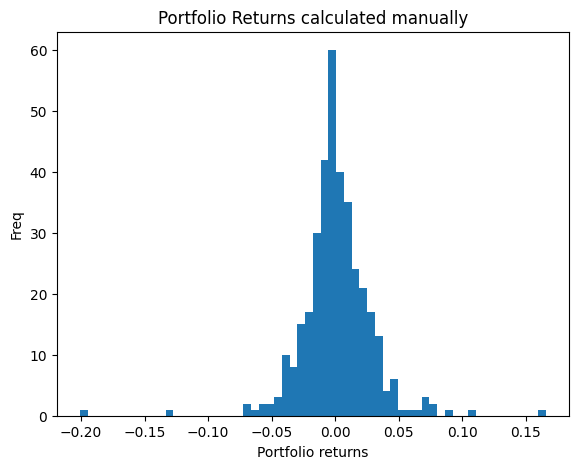

In [8]:
port_ret = weighted_returns.sum(axis=1)

fig = plt.figure()
ax1 = fig.add_axes([0.1,0.1,0.8,0.8])
ax1.hist(port_ret, bins = 60)
ax1.set_xlabel('Portfolio returns')
ax1.set_ylabel("Freq")
ax1.set_title("Portfolio Returns calculated manually")
plt.show(); 

In [9]:
def sortinoRate(rets , TargetReturn):
    downside_returns = np.minimum(0 , rets-TargetReturn)
    downside_variance =  np.mean(downside_returns**2)
    downside_std = np.sqrt(downside_variance)
    sortino_rate = (np.mean(rets) - TargetReturn) / downside_std

    return sortino_rate

# Random Weight statistics

In [10]:
expected_port_return = np.mean(port_ret)
annual_risk_free_ratio = 0.04
daily_risk_free_ratio =  (1+annual_risk_free_ratio) ** (1/365) -1
std_of_returns = np.std(port_ret)
initialCapital = 1000
sharpeRatio = np.sqrt(365) * ((expected_port_return - daily_risk_free_ratio) / std_of_returns)
sortinoRatio = np.sqrt(365) * sortinoRate(port_ret , 0)
port_cumulative_returns  = np.cumprod(1+port_ret)
net_profit_over_time = initialCapital * port_cumulative_returns

final_net_profit = net_profit_over_time[-1] - initialCapital
final_net_profit_percent = final_net_profit/initialCapital * 100
print("Random Weight Sharpe Ratio:{:.2f}".format(sharpeRatio))
print("Random Weight Sortino Ratio:{:.2f}".format(sortinoRatio))
print("Random Weight Net Profit: {:.4f}$".format(final_net_profit) + " percentage:" + "{:.2f}%".format(final_net_profit_percent))

Random Weight Sharpe Ratio:0.72
Random Weight Sortino Ratio:1.14
Random Weight Net Profit: 320.9268$ percentage:32.09%


In [11]:
from scipy.optimize import minimize

# Define the objective functions
def neg_sharpe_ratio(weights, ret_data):
    weighted_returns = (weights * ret_data)
    port_ret = weighted_returns.sum(axis=1)
    expected_port_return = np.mean(port_ret)
    std_of_returns = np.std(port_ret)
    sharpe_ratio = np.sqrt(365) * ((expected_port_return - daily_risk_free_ratio) / std_of_returns)
    return -sharpe_ratio

def neg_net_profit(weights, ret_data):
    weighted_returns = (weights * ret_data)
    port_ret = weighted_returns.sum(axis=1)
    port_cumulative_returns  = np.cumprod(1+port_ret)
    net_profit_over_time = initialCapital * port_cumulative_returns
    final_net_profit = net_profit_over_time[-1] - initialCapital
    return -final_net_profit

def neg_sortino_ratio(weights, ret_data):
    weighted_returns = (weights * ret_data)
    port_ret = weighted_returns.sum(axis=1)
    sortino_ratio = np.sqrt(365) * sortinoRate(port_ret , 0)
    return -sortino_ratio


In [12]:
# Initial guess for the weights
init_guess = [0.25, 0.25, 0.25, 0.25]

# The constraints are that the weights must sum to 1
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

# The bounds are that each weight is between 0 and 1
bounds = ((0, 1), (0, 1), (0, 1), (0, 1))

# Use scipy.optimize.minimize to find the optimal weights
opt_weights_sharpe = minimize(neg_sharpe_ratio, init_guess, args=(ret_data,), method='SLSQP', bounds=bounds, constraints=constraints)
opt_weights_net_profit = minimize(neg_net_profit, init_guess, args=(ret_data,), method='SLSQP', bounds=bounds, constraints=constraints)
opt_weights_sortino = minimize(neg_sortino_ratio, init_guess, args=(ret_data,), method='SLSQP', bounds=bounds, constraints=constraints)

# Print the optimal weights
print("Optimal weights for maximizing Sharpe Ratio: ", opt_weights_sharpe.x)
print("Optimal weights for maximizing Net Profit: ", opt_weights_net_profit.x)
print("Optimal weights for maximizing Sortino Ratio: ", opt_weights_sortino.x)


Optimal weights for maximizing Sharpe Ratio:  [1.00000000e+00 0.00000000e+00 0.00000000e+00 2.23432384e-15]
Optimal weights for maximizing Net Profit:  [9.99999999e-01 6.94414573e-10 1.00000000e-10 8.75119802e-10]
Optimal weights for maximizing Sortino Ratio:  [9.22251008e-01 5.55111512e-17 0.00000000e+00 7.77489915e-02]
